# Install dependencies

In [1]:

!pip install -q xgboost shap scikit-learn imbalanced-learn matplotlib seaborn plotly joblib


# Import and settings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
                             RocCurveDisplay, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

sns.set(style='whitegrid')
RND = 42


Load data

In [5]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.shape, df.head(3)

((7043, 21),
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...               No   
 1                No             DSL            Yes  ...              Yes   
 2                No             DSL            Yes  ...               No   
 
   TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
 0          No          No              No  Month-to-month              Yes   
 1          No          No              No        One year               No   
 2          No          No              No  Month-to-month              Yes   
 
       PaymentMethod MonthlyCharg

# Understand target and missing values (EDA)

In [6]:
print("Columns:", df.columns.tolist())
print("\nMissing values:")
print(df.isnull().sum())
print("\nTarget distribution:")
print(df['Churn'].value_counts(normalize=True))

# Basic numeric summary
display(df.describe(include='all').T)


Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Target distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clean and feature engineering

In [7]:
# Clean TotalCharges (it can be object because of spaces)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop customerID (ID column not useful)
df = df.drop(columns=['customerID'])

# Fill NA - simple approach
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Create some features
df['tenure_group'] = pd.cut(df['tenure'], bins=[-1, 6, 12, 24, 48, 72], labels=['0-6','7-12','13-24','25-48','49-72'])
df['AvgChargesPerMonth'] = df['TotalCharges'] / (df['tenure'].replace(0,1))

# Convert target to binary
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,AvgChargesPerMonth
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-6,29.850000
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,0,25-48,55.573529
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-6,54.075000
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,25-48,40.905556
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-6,75.825000


# Visualization examples

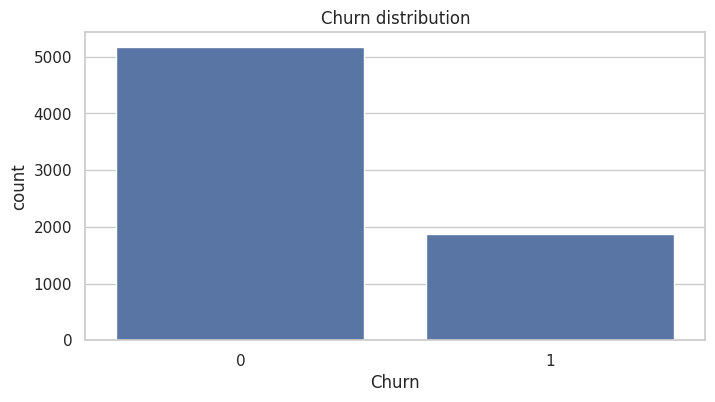

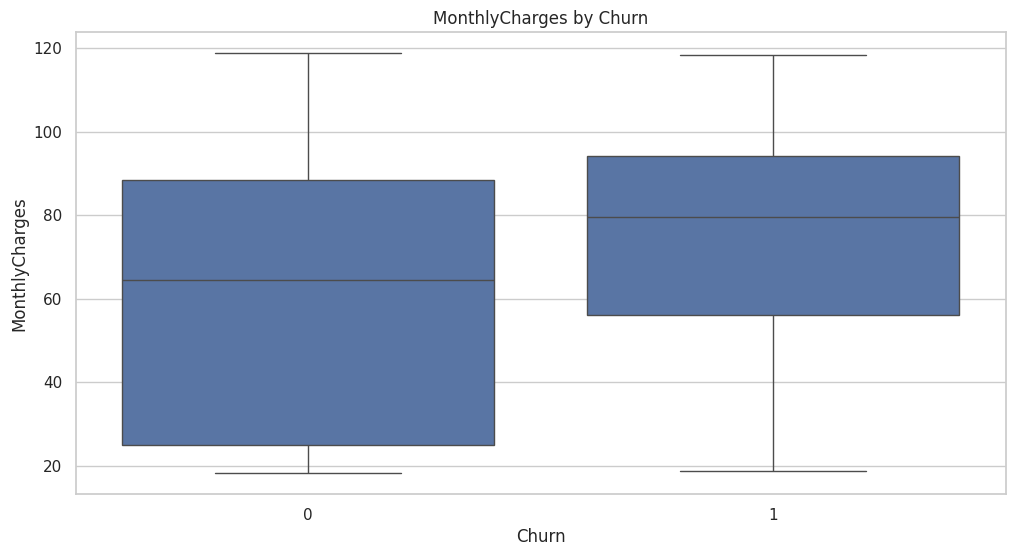

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(x='Churn', data=df)
plt.title('Churn distribution')
plt.savefig('/content/churn_distribution.png', bbox_inches='tight'); plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('MonthlyCharges by Churn')
plt.savefig('/content/monthlycharges_by_churn.png', bbox_inches='tight'); plt.show()


Prepare features (Split categorical/numerical)

In [9]:
TARGET = 'Churn'
y = df[TARGET]
X = df.drop(columns=[TARGET])

# Identify numeric and categorical
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)


Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargesPerMonth']
Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']


# Build preprocessing + model pipeline

In [10]:
# Preprocessor
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

# Train split (stratified)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RND
)
print(X_train.shape, X_test.shape, y_train.mean())


(5634, 21) (1409, 21) 0.2653532126375577


# Modeling: train 3 models with default params (quick compare)

In [12]:
models = {
    'Logistic': Pipeline([('prep', preprocessor), ('clf', LogisticRegression(max_iter=1000, random_state=RND))]),
    'RandomForest': Pipeline([('prep', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=RND))]),
    'XGBoost': Pipeline([('prep', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND))])
}

results = {}
for name, pipe in models.items():
    # Fit - using SMOTE to balance training data manually
    X_tr_pre = preprocessor.fit_transform(X_train)
    # Need to get feature matrix for SMOTE using numeric + OHE
    sm = SMOTE(random_state=RND)
    X_res, y_res = sm.fit_resample(X_tr_pre, y_train)
    # Fit classifier separately (so preprocessor not applied twice)
    clf = pipe.named_steps['clf']
    clf.fit(X_res, y_res)
    # Build a pipeline wrapper for predict pipeline convenience
    full_pipe = Pipeline([('prep', preprocessor), ('clf', clf)])
    preds = full_pipe.predict(X_test)
    probs = full_pipe.predict_proba(X_test)[:,1]
    results[name] = {
        'model': full_pipe,
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1': f1_score(y_test, preds),
        'roc_auc': roc_auc_score(y_test, probs)
    }

pd.DataFrame(results).T[['accuracy','precision','recall','f1','roc_auc']].sort_values('roc_auc', ascending=False)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:08:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,accuracy,precision,recall,f1,roc_auc
Logistic,0.7445,0.512027,0.796791,0.623431,0.84308
XGBoost,0.777857,0.584022,0.566845,0.575305,0.822103
RandomForest,0.774308,0.575676,0.569519,0.572581,0.821935


# Hyperparameter tuning (RandomizedSearchCV on XGBoost)

In [13]:
param_dist = {
    'clf__n_estimators':[100,200,400],
    'clf__max_depth':[3,5,7],
    'clf__learning_rate':[0.01,0.05,0.1],
    'clf__subsample':[0.6,0.8,1.0],
    'clf__colsample_bytree':[0.6,0.8,1.0]
}

xgb_pipeline = Pipeline([('prep', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND))])

# Note: Wrap SMOTE manually in cross-validation by resampling in each CV fold using a small function OR use imblearn's Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
imb_pipeline = ImbPipeline([('prep', preprocessor), ('smote', SMOTE(random_state=RND)), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND))])

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RND)
rs = RandomizedSearchCV(imb_pipeline, param_distributions=param_dist, n_iter=20, scoring='roc_auc', cv=cv, verbose=1, n_jobs=-1, random_state=RND)
rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
best_model = rs.best_estimator_


Fitting 4 folds for each of 20 candidates, totalling 80 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:11:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'clf__subsample': 1.0, 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.8}


# Final evaluation & plots (confusion matrix, ROC)

              precision    recall  f1-score   support

           0     0.8742    0.8126    0.8423      1035
           1     0.5660    0.6765    0.6163       374

    accuracy                         0.7764      1409
   macro avg     0.7201    0.7445    0.7293      1409
weighted avg     0.7924    0.7764    0.7823      1409

ROC AUC: 0.8434459686377844


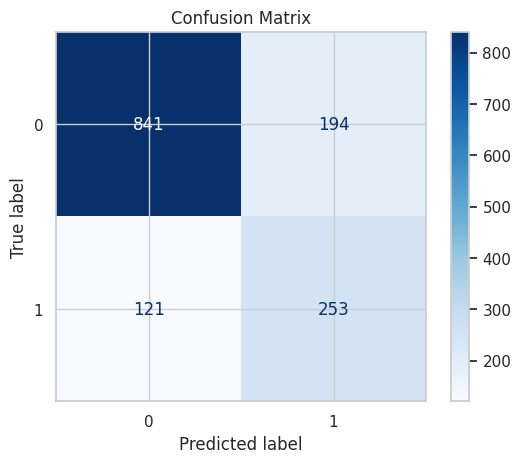

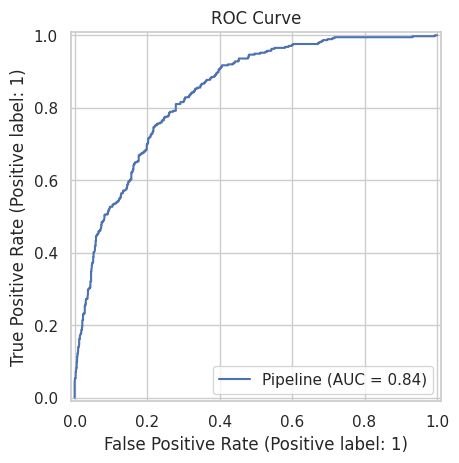

In [14]:
# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

# Metrics
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('/content/confusion_matrix.png', bbox_inches='tight')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve")
plt.savefig('/content/roc_curve.png', bbox_inches='tight')
plt.show()


# Feature importance

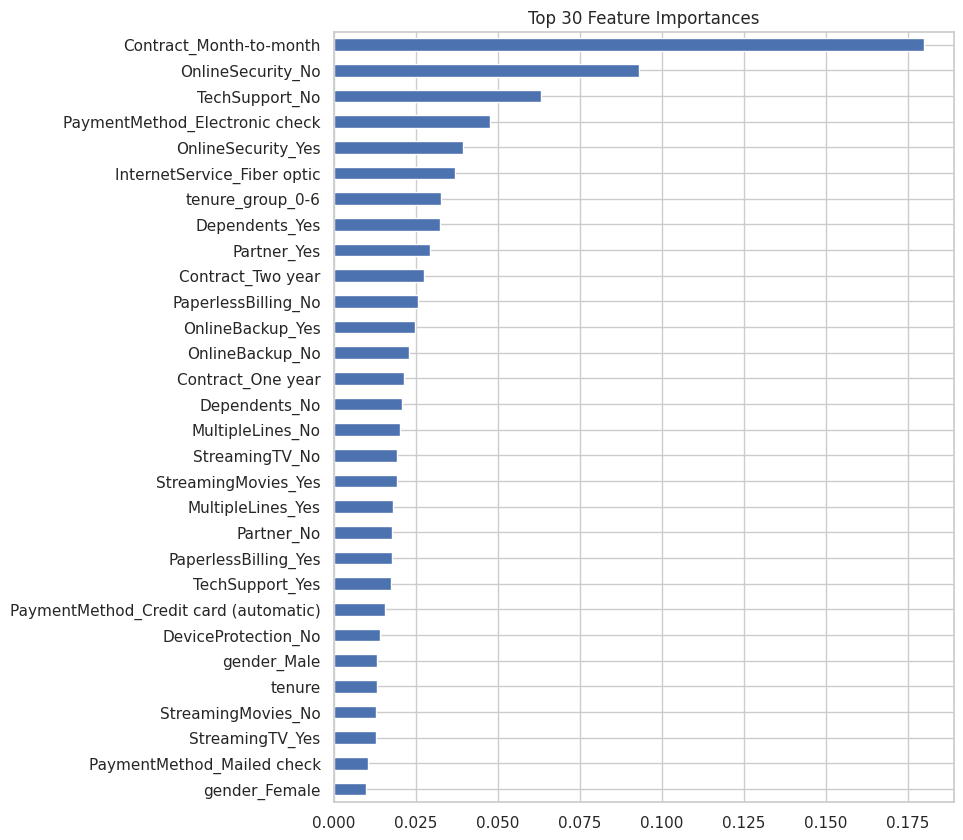

In [15]:
# If the pipeline is imblearn pipeline, classifier is last named step 'clf'
clf = best_model.named_steps['clf']
# Need feature names after preprocessing
ohe = best_model.named_steps['prep'].named_transformers_['cat'].named_steps['ohe']
cat_names = ohe.get_feature_names_out(cat_cols)
feature_names = list(num_cols) + list(cat_names)

importances = clf.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
plt.figure(figsize=(8,10))
feat_imp.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 30 Feature Importances')
plt.savefig('/content/feature_importance.png', bbox_inches='tight')
plt.show()


# SHAP explainability (global + local)

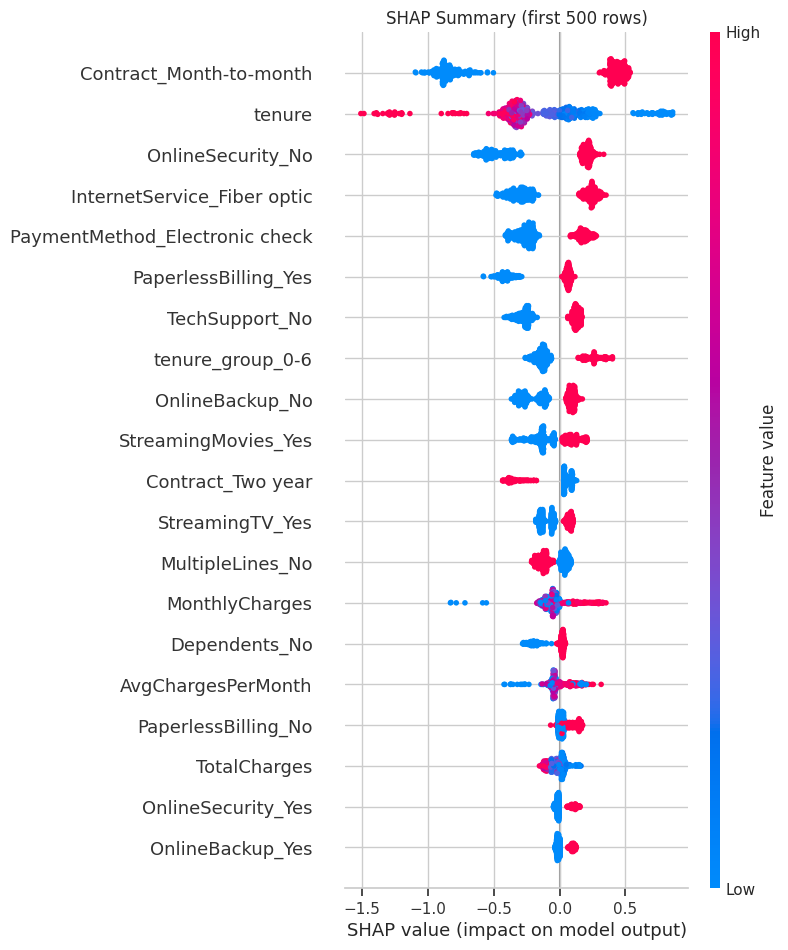

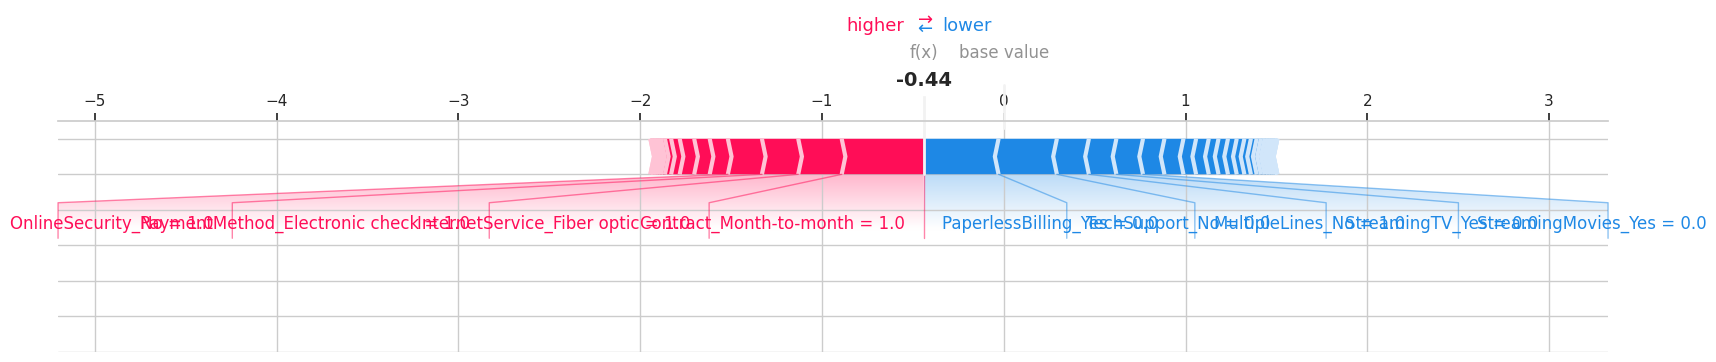

In [16]:
# Use a small background sample for speed
X_train_trans = best_model.named_steps['prep'].transform(X_train)
explainer = shap.TreeExplainer(best_model.named_steps['clf'])
# sample
bg = shap.sample(X_train_trans, 200, random_state=RND)
X_test_trans = best_model.named_steps['prep'].transform(X_test)
shap_values = explainer.shap_values(X_test_trans[:500])  # compute for first 500 rows

# Summary plot (global)
shap.summary_plot(shap_values, X_test_trans[:500], feature_names=feature_names, show=False)
plt.title('SHAP Summary (first 500 rows)')
plt.savefig('/content/shap_summary.png', bbox_inches='tight')
plt.show()

# Local explanation for one customer
i = 3
shap.force_plot(explainer.expected_value, shap_values[i], X_test_trans[i], feature_names=feature_names, matplotlib=True, show=False)
plt.savefig('/content/shap_force_{}_matplotlib.png'.format(i), bbox_inches='tight')
plt.show()


In [17]:
import joblib
joblib.dump(best_model, '/content/best_churn_model.pkl')


['/content/best_churn_model.pkl']